# BBC News 文本分类数据集：探索性数据分析（EDA）

本 Notebook 对 BBC News 文本分类数据集进行探索性数据分析（EDA），目的包括：

1. **理解数据规模与标签分布**：判断是否存在类别不平衡，以及后续评估指标应偏向 Accuracy 还是 Macro-F1。  
2. **理解文本长度特征**：为向量化方法（BoW/TF-IDF）与模型选择提供依据。  
3. **分析词汇与类别区分性**：观察每个类别的典型高频词，判断该任务是否存在强词汇线索（lexical cues）。  
4. **给出建模启示**：将 EDA 结果明确映射到后续实验设计（特征、模型与参数）。


## 1. 数据集说明

- 数据来源：BBC News 文本分类数据集  
- 数据格式：CSV  
- 关键字段：  
  - `text`：新闻文本（包含较长内容，而不只是标题）  
  - `labels`：类别标签（business / entertainment / politics / sport / tech）

> 说明：本 Notebook 的清洗与分词主要用于 EDA 统计；实际建模（尤其是 BERT）会使用不同 tokenizer。


In [1]:
# --- Imports ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams["figure.dpi"] = 120


## 2. 加载数据与完整性检查

我们首先加载数据，并检查：
- 数据规模（样本数、列数）
- 列类型
- 缺失值情况

若你的 CSV 列名不是 `text` / `labels`，可以在后续的重命名 cell 中映射。


In [2]:
# --- Load your dataset ---
# Option A: set a local path directly
DATA_PATH = "/home/mywsl/Workspace/NLP/data/bbc_text_cls.csv"  # <-- 按需修改

# Option B: if you are using your Config class, you can do:
# from src.config import Config
# DATA_PATH = str(Config().dataset_csv)

df = pd.read_csv(DATA_PATH)
df.head()


text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business

In [3]:
# --- Basic info ---
print("Shape:", df.shape)
print(df.dtypes)
print("\nMissing values:\n", df.isna().sum())


Shape: (2225, 2)
text      object
labels    object
dtype: object

Missing values:
 text      0
labels    0
dtype: int64


###（可选）重命名列

如果你的 CSV 使用不同列名（比如 `category` / `label` / `headline`），在这里做映射。  
执行后请确保最终列名为：`text` 与 `labels`。


In [4]:
# 如果需要，取消注释并调整：
# df = df.rename(columns={"headline": "text", "label": "labels"})
# assert "text" in df.columns and "labels" in df.columns, "CSV must contain columns: text, labels"


## 3. 类别分布（Class Distribution）

目的：
- 检查类别是否均衡
- 为后续评估指标选择提供依据（Accuracy vs Macro-F1）

如果类别严重不均衡，Accuracy 可能误导，需要更关注 Macro-F1 / Macro-Recall 等指标。


In [5]:
class_counts = df["labels"].value_counts()
class_counts


labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

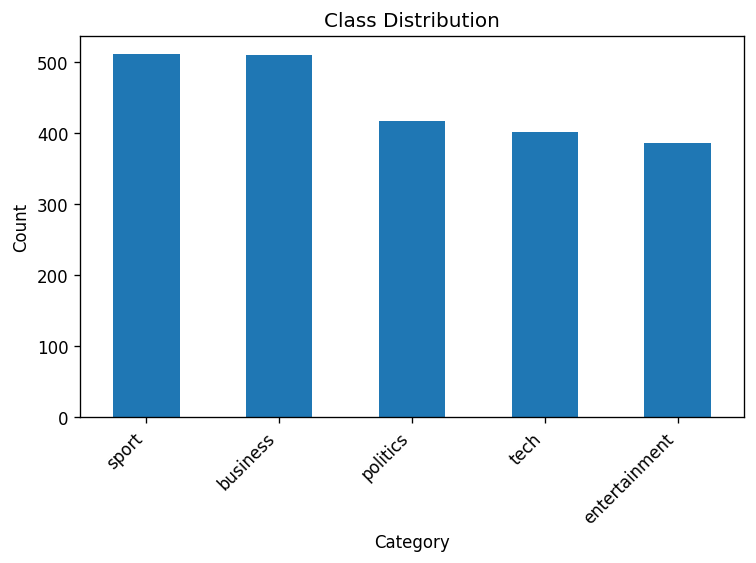

In [6]:
plt.figure()
class_counts.sort_values(ascending=False).plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 4. 文本长度分析（Text Length Analysis）

我们统计两种长度：
- `char_len`：字符数
- `tok_len`：按空格切分的 token 数

目的：
- 判断文本是否偏短/偏长
- 估计后续模型（尤其是 Transformer）可能需要的截断长度


In [7]:
df["char_len"] = df["text"].astype(str).apply(len)
df["tok_len"] = df["text"].astype(str).apply(lambda x: len(x.split()))

df[["char_len", "tok_len"]].describe().T


count         mean          std    min     25%     50%     75%  \
char_len  2225.0  2264.157753  1364.095679  502.0  1447.0  1966.0  2803.0   
tok_len   2225.0   384.040449   238.174497   89.0   246.0   332.0   471.0   

              max  
char_len  25484.0  
tok_len    4432.0

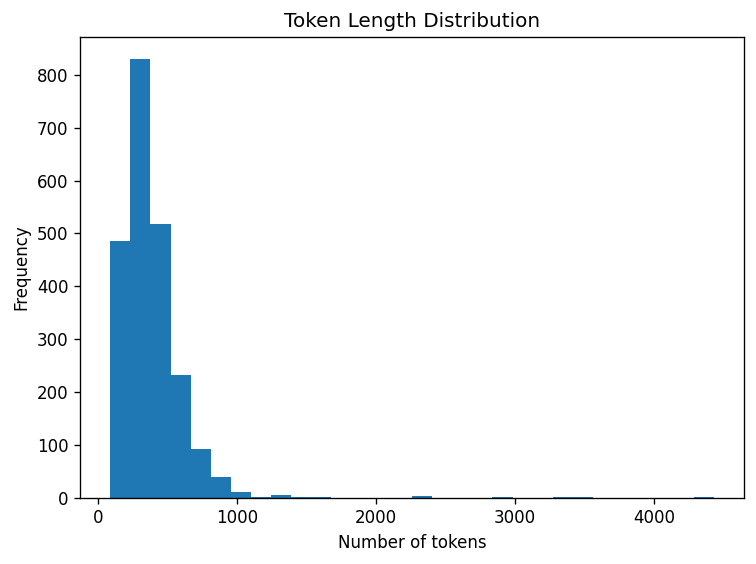

In [8]:
plt.figure()
plt.hist(df["tok_len"], bins=30)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


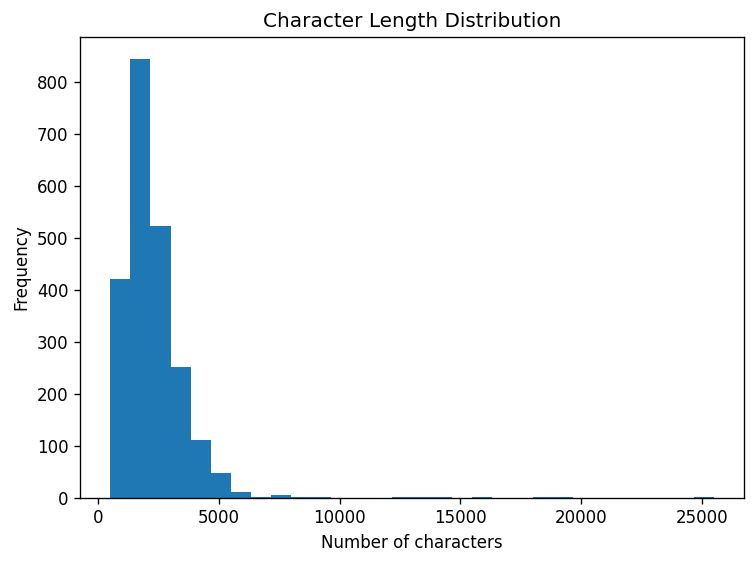

In [9]:
plt.figure()
plt.hist(df["char_len"], bins=30)
plt.title("Character Length Distribution")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 4.1 不同类别的长度对比

某些主题可能系统性更长（例如 tech/politics 可能更解释性、术语更多）。  
这里用 groupby 统计各类 token 长度均值/中位数，并用 boxplot 做可视化。


In [10]:
grp = df.groupby("labels")["tok_len"].agg(["count", "mean", "median", "min", "max"]).sort_values("mean", ascending=False)
grp


count        mean  median  min   max
labels                                             
tech             401  502.695761   447.0  162  2969
politics         417  453.973621   439.0   89  4432
entertainment    386  330.621762   262.5  143  3482
sport            511  329.262231   288.0  114  1662
business         510  328.880392   297.0  140   891

/tmp/ipykernel_136318/1573191951.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories, showfliers=False)


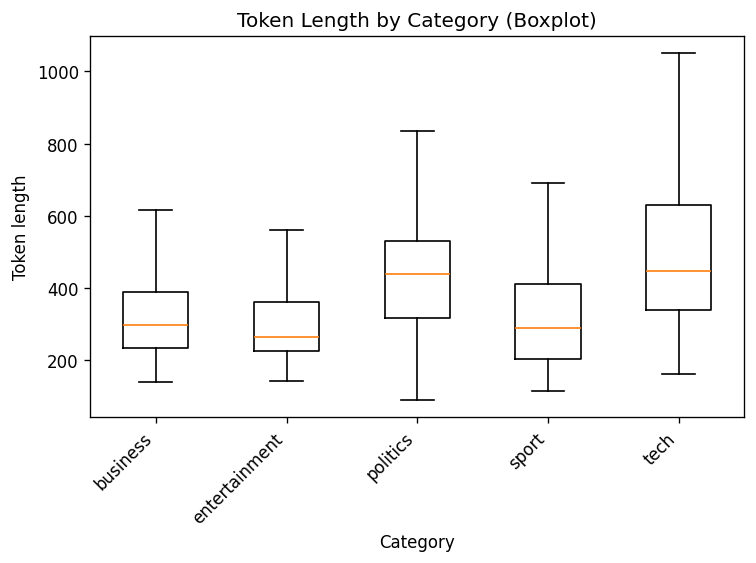

In [11]:
plt.figure()
categories = df["labels"].unique().tolist()
data = [df.loc[df["labels"] == c, "tok_len"].values for c in categories]
plt.boxplot(data, labels=categories, showfliers=False)
plt.title("Token Length by Category (Boxplot)")
plt.xlabel("Category")
plt.ylabel("Token length")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 5. 轻量级清洗与分词（用于 EDA）

为了做词频统计，我们使用一个轻量 tokenizer：
- 全部小写
- 仅保留英文单词（允许词内撇号，如 `bbc's`）

> 注意：这只是 EDA 用的统计 tokenizer，不等同于建模 tokenizer。


In [12]:
def simple_tokenize(text: str):
    text = str(text).lower()
    # keep alphabetic words (and apostrophes within words)
    tokens = re.findall(r"[a-z]+(?:'[a-z]+)?", text)
    return tokens

# quick demo
simple_tokenize("Hello, BBC's markets fall 3% today!")


['hello', "bbc's", 'markets', 'fall', 'today']

## 6. 全局高频词（Overall Frequent Words）

目的：
- 检查语料是否正常（是否存在奇怪 token、噪声）
- 观察 stopwords 主导的情况（新闻语料通常如此）

后续会进一步按类别统计，并可选择去除高频词（近似 stopwords）来突出主题词。


In [13]:
all_tokens = []
for t in df["text"]:
    all_tokens.extend(simple_tokenize(t))

freq_all = Counter(all_tokens)
freq_all.most_common(20)


[('the', 52636),
 ('to', 25113),
 ('of', 20008),
 ('and', 18612),
 ('a', 18342),
 ('in', 17734),
 ('for', 8945),
 ('is', 8555),
 ('that', 8055),
 ('on', 7624),
 ('said', 7255),
 ('it', 7011),
 ('was', 6028),
 ('be', 5805),
 ('he', 5785),
 ('with', 5354),
 ('as', 4981),
 ('has', 4957),
 ('have', 4772),
 ('at', 4638)]

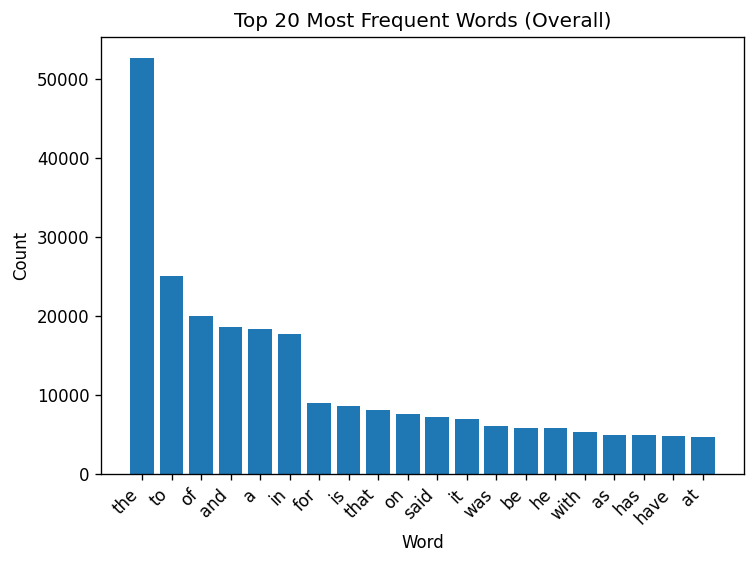

In [14]:
# Plot top-k words
top_k = 20
words, counts = zip(*freq_all.most_common(top_k))

plt.figure()
plt.bar(words, counts)
plt.title(f"Top {top_k} Most Frequent Words (Overall)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 7. 按类别的高频词（Frequent Words by Category）

这是主题分类中最有信息量的 EDA：  
每个类别是否存在明显“主题专属词”，从而支持 TF-IDF + 线性模型的合理性。


In [15]:
def all_words_by_category(df, category_col="labels", text_col="text"):
    out = {}
    for cat in sorted(df[category_col].unique()):
        tokens = []
        sub = df[df[category_col] == cat]
        for t in sub[text_col]:
            tokens.extend(simple_tokenize(t))
        out[cat] = Counter(tokens)
    return out

all_words = all_words_by_category(df)


In [16]:
def top_words_by_category(df, category_col="labels", text_col="text", top_k=15):
    out = {}
    for cat in sorted(df[category_col].unique()):
        tokens = []
        sub = df[df[category_col] == cat]
        for t in sub[text_col]:
            tokens.extend(simple_tokenize(t))
        out[cat] = Counter(tokens).most_common(top_k)
    return out

top_by_cat = top_words_by_category(df, top_k=15)
top_by_cat


{'business': [('the', 10819),
  ('to', 5086),
  ('of', 4383),
  ('in', 4332),
  ('a', 3457),
  ('and', 3208),
  ('said', 1680),
  ('for', 1615),
  ('is', 1608),
  ('that', 1584),
  ('it', 1414),
  ('on', 1382),
  ('has', 1252),
  ('its', 1100),
  ('by', 1098)],
 'entertainment': [('the', 8269),
  ('and', 3019),
  ('of', 2973),
  ('to', 2903),
  ('in', 2817),
  ('a', 2749),
  ('for', 1543),
  ('on', 1176),
  ('was', 1140),
  ('is', 1082),
  ('with', 946),
  ('it', 871),
  ('at', 835),
  ('said', 825),
  ('he', 805)],
 'politics': [('the', 12184),
  ('to', 6004),
  ('of', 4471),
  ('and', 3974),
  ('a', 3912),
  ('in', 3396),
  ('said', 2241),
  ('he', 2201),
  ('for', 1920),
  ('that', 1909),
  ('on', 1860),
  ('is', 1837),
  ('mr', 1686),
  ('be', 1676),
  ('was', 1576)],
 'sport': [('the', 9657),
  ('to', 4721),
  ('a', 3867),
  ('and', 3688),
  ('in', 3673),
  ('of', 2817),
  ('for', 1751),
  ('i', 1631),
  ('he', 1629),
  ('on', 1512),
  ('is', 1492),
  ('but', 1450),
  ('was', 1426

In [17]:
# Pretty print
for cat, items in top_by_cat.items():
    print("\n===", cat, "===")
    print(", ".join([f"{w}({c})" for w, c in items]))



=== business ===
the(10819), to(5086), of(4383), in(4332), a(3457), and(3208), said(1680), for(1615), is(1608), that(1584), it(1414), on(1382), has(1252), its(1100), by(1098)

=== entertainment ===
the(8269), and(3019), of(2973), to(2903), in(2817), a(2749), for(1543), on(1176), was(1140), is(1082), with(946), it(871), at(835), said(825), he(805)

=== politics ===
the(12184), to(6004), of(4471), and(3974), a(3912), in(3396), said(2241), he(2201), for(1920), that(1909), on(1860), is(1837), mr(1686), be(1676), was(1576)

=== sport ===
the(9657), to(4721), a(3867), and(3688), in(3673), of(2817), for(1751), i(1631), he(1629), on(1512), is(1492), but(1450), was(1426), that(1219), with(1209)

=== tech ===
the(11707), to(6399), of(5364), and(4723), a(4357), in(3516), that(2595), is(2536), for(2116), it(2074), on(1694), be(1614), are(1576), said(1567), as(1415)


## 8. 词云可视化（可选）

词云可以更直观展示各类别词汇差异。  
如果你没有安装 `wordcloud`，可以运行：

```bash
pip install wordcloud
```

注意：在某些环境（例如只读服务器）可能无法安装包，此时可跳过本节。


In [18]:
# 可选：词云
# 如果未安装：pip install wordcloud

from wordcloud import WordCloud


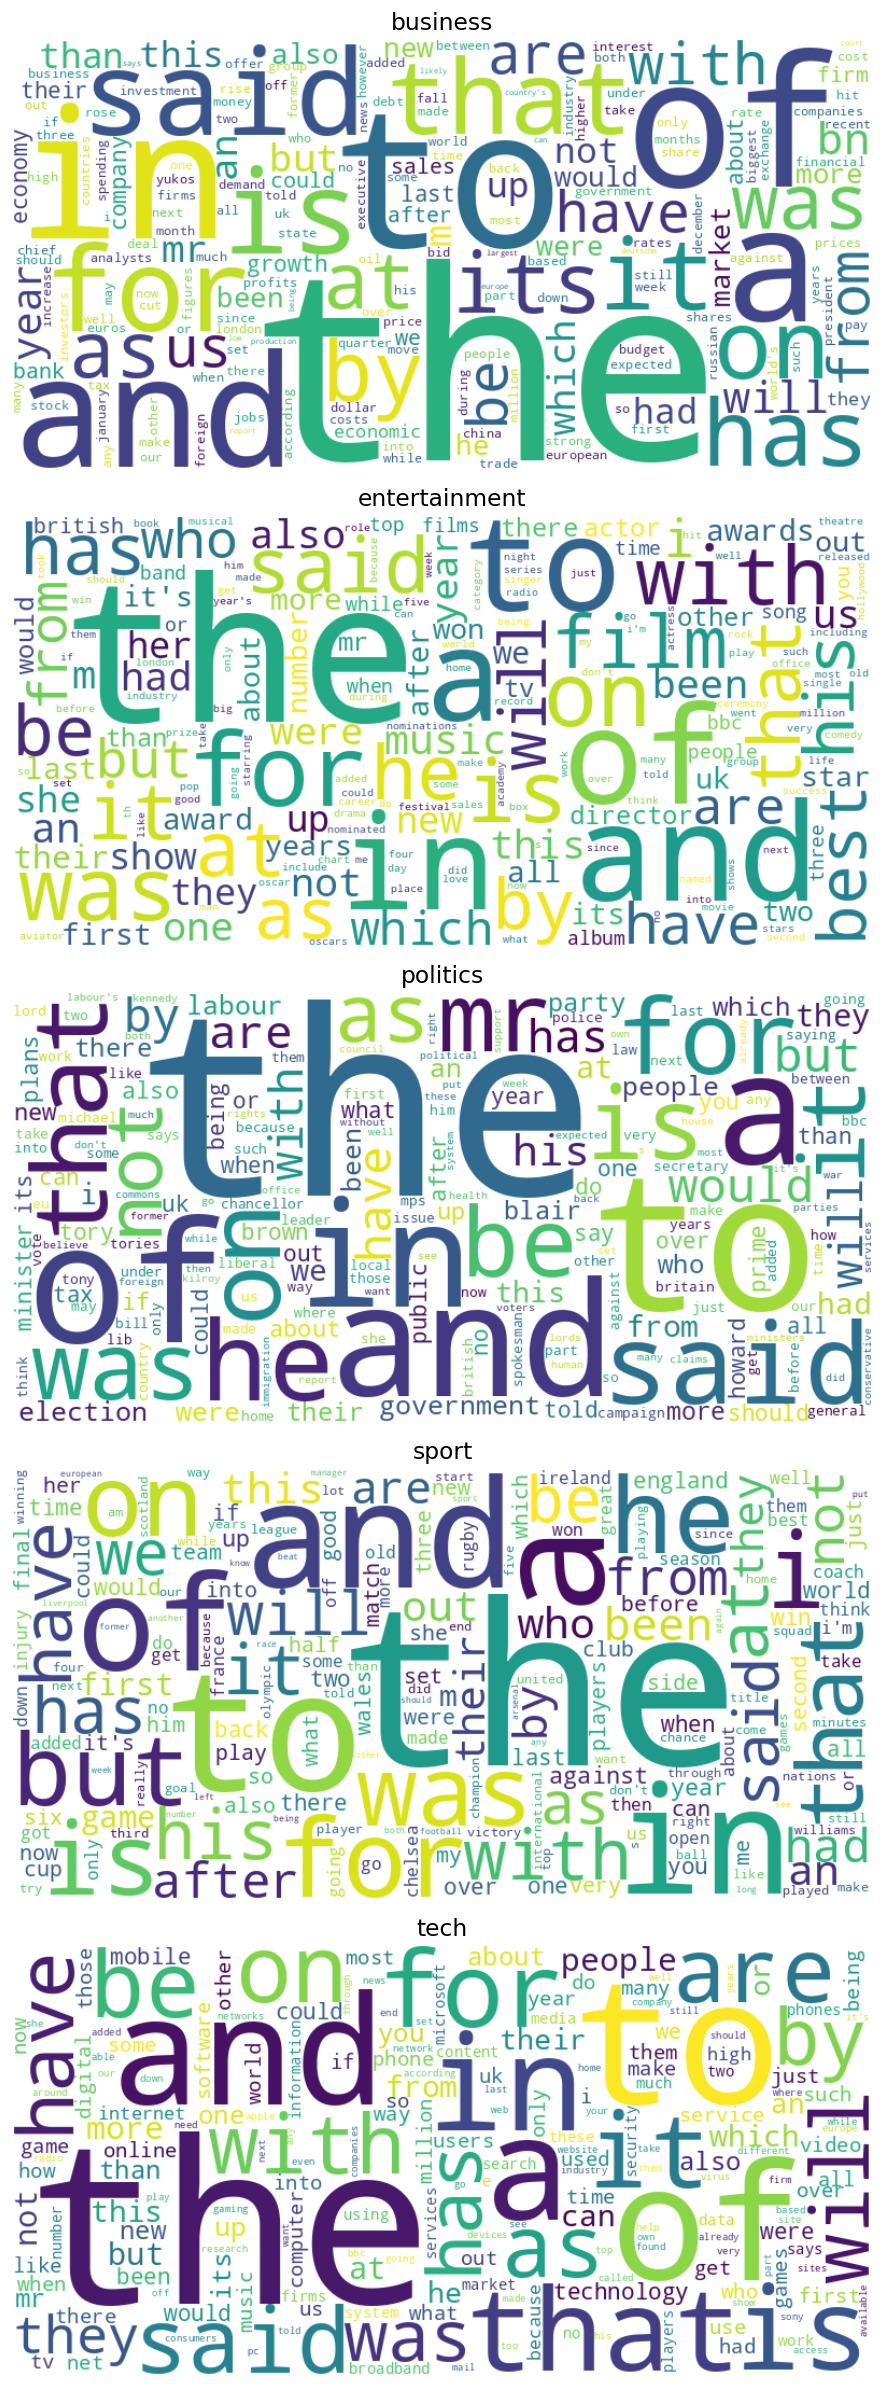

In [19]:
def plot_wordclouds_all_words(all_words, figsize_per_row=(15, 4)):
    cats = list(all_words.keys())
    n = len(cats)
    fig, axes = plt.subplots(n, 1, figsize=(figsize_per_row[0], figsize_per_row[1] * n))
    if n == 1:
        axes = [axes]
    for ax, cat in zip(axes, cats):
        freq_dict = dict(all_words[cat])
        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=200,
            collocations=False
        ).generate_from_frequencies(freq_dict)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(cat, fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_wordclouds_all_words(all_words)


### 8.1 去除高频词后的词云（更突出主题词）

由于 stopwords 会占据主导，我们可以在每个类别中移除 top-N 高频词（近似 stopwords），
从而让词云更突出“主题专属词”。


In [20]:
def remove_top_words_per_category(all_words, top_n=60):
    cleaned = {}
    for cat, counter in all_words.items():
        top_words = {w for w, _ in counter.most_common(top_n)}
        filtered = {w: c for w, c in counter.items() if w not in top_words}
        cleaned[cat] = filtered
    return cleaned

filtered_words = remove_top_words_per_category(all_words, top_n=60)


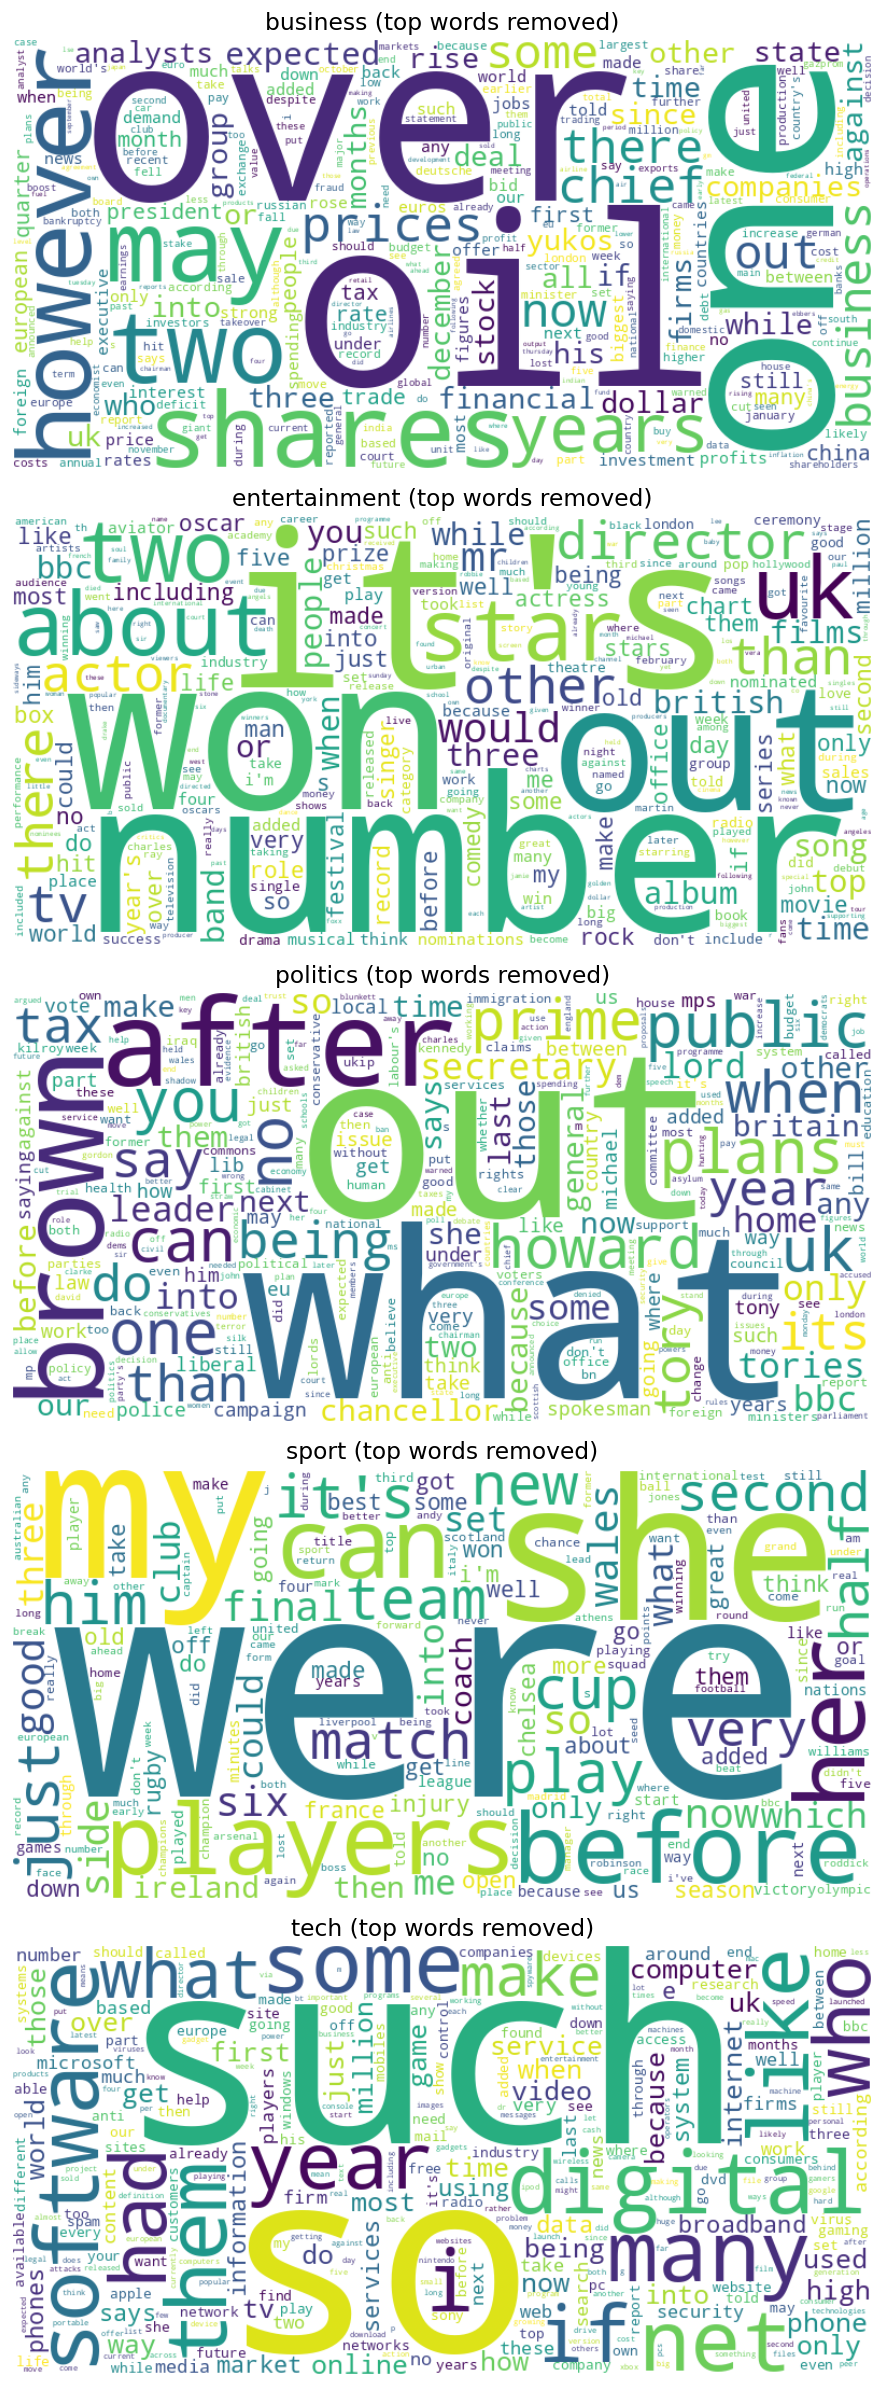

In [21]:
def plot_wordclouds(filtered_words, figsize_per_row=(15, 4)):
    cats = list(filtered_words.keys())
    n = len(cats)
    fig, axes = plt.subplots(n, 1, figsize=(figsize_per_row[0], figsize_per_row[1] * n))
    if n == 1:
        axes = [axes]
    for ax, cat in zip(axes, cats):
        freq_dict = filtered_words[cat]
        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=300,
            min_font_size=6,
            collocations=False
        ).generate_from_frequencies(freq_dict)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"{cat} (top words removed)", fontsize=14)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_wordclouds(filtered_words)


## 9. 词表规模与稀有词（Vocabulary Size & Rare Words）

我们统计：
- 总 token 数
- 词表大小（unique word types）
- 只出现一次的稀有词数量及比例

稀有词比例高通常意味着：
- 专有名词很多（人名、地名、公司名）
- 噪声/拼写变体存在
- 可能出现 OOV 问题（对传统词表方法而言）

因此在 TF-IDF 中常用 `min_df` 限制低频词，或用子词模型缓解 OOV。


In [22]:
vocab = set(freq_all.keys())
vocab_size = len(vocab)
n_tokens = sum(freq_all.values())
n_rare = sum(1 for w, c in freq_all.items() if c == 1)
rare_ratio = n_rare / vocab_size if vocab_size else 0

print("Total tokens:", n_tokens)
print("Vocab size:", vocab_size)
print("Rare words (count==1):", n_rare)
print("Rare word ratio:", round(rare_ratio, 4))


Total tokens: 847950
Vocab size: 29503
Rare words (count==1): 10081
Rare word ratio: 0.3417


## 10. TF-IDF sanity check（可选，但建议保留用于报告）

由于传统模型（TF-IDF + 线性分类器）在该类数据上往往表现很好，
记录 TF-IDF 的基本统计有助于写报告：
- 矩阵形状（样本数 × 特征维度）
- 词表大小
- 稀疏度（0 的比例）


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

X = vectorizer.fit_transform(df["text"].astype(str))
print("TF-IDF matrix shape:", X.shape)
print("TF-IDF vocab size:", len(vectorizer.vocabulary_))

# sparsity = proportion of zero entries
sparsity = 1.0 - (X.nnz / (X.shape[0] * X.shape[1]))
print("Sparsity:", round(sparsity, 4))


TF-IDF matrix shape: (2225, 77505)
TF-IDF vocab size: 77505
Sparsity: 0.9972


## 11. EDA 总结与建模启示（请在提交前务必保留）

基于以上 EDA，我们可以得到如下关键结论（可直接用于报告正文）：

1. **数据规模与分布**：数据集共有 2225 条样本，5 个类别整体较均衡，因此 Accuracy 有参考价值，但仍建议报告 Macro-F1 以反映各类表现。  
2. **文本长度特征**：文本并非短标题，而是较长新闻内容，长度分布存在长尾（少量超长文本）。不同类别长度差异明显（tech/politics 更长）。  
3. **词汇区分性强**：按类别统计后可观察到大量主题专属词（如 business 的 finance/market 相关词，sport 的 match/player 等）。这说明任务具有强 lexical cues。  
4. **传统方法合理性**：TF-IDF 特征空间高维且高度稀疏（接近 1），这是典型文本分类形态；在强 lexical cues 场景下，线性分类器（Logistic Regression / Linear SVM）通常能达到很强基线。  
5. **稀有词比例**：稀有词比例较高提示可能存在 OOV/专有名词问题，传统模型可通过 `min_df` 降噪；子词模型（BERT）能缓解 OOV，但在此任务上增益可能受限于“线性模型已接近上限”的数据特性。

> 以上“EDA → 建模选择”的显式映射，通常是从 **Good** 拉到 **Excellent** 的关键。
